In [59]:
import torch
import os
import pandas as pd
from PIL import Image


class AfricanWildlifeDataset(torch.utils.data.Dataset):
    def __init__(
        self, train_dir, test_dir, label_dir, S=7, B=2, C=4, transform=None, istesting=False
    ):
        self.annotations = label_dir
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform
        self.istesting = istesting       
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(os.listdir(self.annotations))     

    def __getitem__(self, index):
        #path to label
        
        if not self.istesting: 
            file = os.listdir(self.train_dir)
            img_path = f'{self.train_dir}/{file[index]}'
        else: 
            file = os.listdir(self.test_dir)
            img_path = f'{self.test_dir}/{file[index]}'
        
        label_name = file[index].split('.')[0]
        label_path = f'{self.annotations}/{label_name}.txt'
        
        boxes = []
        with open(label_path) as f: # open the image 
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])
            
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        # if there are any transformations
        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B)) # one bounding box per cell
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 4] == 0:
                # Set that there exists an object
                label_matrix[i, j, 4] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 5:9] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [60]:
S = 7
class_label, x, y, width, height = [0, 0.56, 0.66, 0.61, 0.64]

class_label = int(class_label)
print(class_label)

i, j = int(S * y), int(S * x)
print(i, j)
x_cell, y_cell = S * x - j, S * y - i
print(x_cell, y_cell)

0
4 3
0.9200000000000004 0.6200000000000001


In [61]:
label_matrix = torch.zeros((7, 7, 14))
print(label_matrix)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [62]:
train_dir = 'African Wildlife/train'
test_dir = 'African Wildlife/test'
label_dir = 'African Wildlife/annotations'

data = AfricanWildlifeDataset(train_dir, test_dir, label_dir)
print(data.__getitem__(1))

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x23F209E1520>, tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.

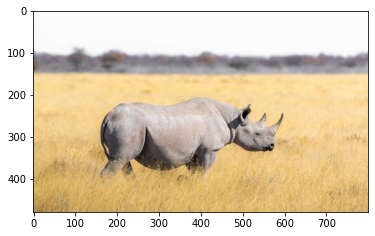

In [63]:
import matplotlib.pyplot as plt
img, label = data.__getitem__(56)
plt.imshow(img)